In [1]:
import tkinter as tk
from solcore.solar_cell_solver import solar_cell_solver
import time
# from lib_save_file import *
from lib_save_data import *
# from material_of_InSb_GaSb import *
from material_and_layer_QD import *
from solcore.light_source import LightSource
import matplotlib.pyplot as plt
import solcore.poisson_drift_diffusion as PDD
from solcore.structure import SolcoreMaterialToStr, ToStructure, ToLayer, InLineComposition
import mpld3
# import numpy as np
from matplotlib import pyplot as plt, cm, ticker
from solcore.poisson_drift_diffusion.DriftDiffusionUtilities import SetMeshParameters
from solcore.structure import SolcoreMaterialToStr
# from numpy import trapz
# from solcore.light_source import LightSource
from material_of_InSb_GaSb import *
from material_and_layer_QD import *
from lib_save_file import *
from solcore.solar_cell_solver import solar_cell_solver
from solcore.light_source import LightSource
import time


C:\Users\usuwa\anaconda3\Lib\site-packages\solcore\registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


In [1]:
from solcore.state import State
import mpld3
from matplotlib import pyplot as plt, cm, ticker
from material_of_InSb_GaSb import *
from material_and_layer_QD import *
from lib_save_file import *
from solcore.solar_cell_solver import solar_cell_solver
import time
from constant import *

# vint = np.linspace(-3, 3, 600)
# V = np.linspace(-1.5, 0, 300)  # np

# wl = np.linspace(350, 3000, 1001) * 1e-9  # version1
# light_source = LightSource(source_type="standard"
#                            , version="AM1.5g"
#                            , x=wl
#                            , output_units="photon_flux_per_m"
#                            , concentration=1
#                            )
data_solar_cell = dict(
    T=None,
    absorbed=None,
    short_circuit_data=None,
    pdd_data=None,
    recombination_currents=None,
    equilibrium_data=None,
    iv=None,
    qe=None,
    offset=0,
    note='note',
    list_structure=[],
    x_axis=[],
    x_axis_name='None',
    mode='None',

)


def defultsaveing(solarcell, saveaddrest, version, save=True):
    saveaddrest["T"] = solarcell.T
    saveaddrest['absorbed'] = solarcell.absorbed
    saveaddrest['short_circuit_data'] = solarcell[0].short_circuit_data.copy()
    saveaddrest['pdd_data'] = solarcell[0].pdd_data.copy()
    saveaddrest['recombination_currents'] = solarcell[0].recombination_currents.copy()
    saveaddrest['equilibrium_data'] = solarcell[0].equilibrium_data.copy()
    saveaddrest['iv'] = solarcell.iv.copy()
    saveaddrest['offset'] = solarcell[0].offset
    saveaddrest['qe'] = solarcell[0].qe.copy()
    if save:
        with open(f'{version}.pkl', 'wb') as fin:
            pickle.dump(saveaddrest, fin)
            print('dictionary saved successfully to file')
    return saveaddrest


def load_old_data(version):
    with open(f'{version}', 'rb') as fp:
        data = pickle.load(fp)
    print('Loading dictionary complete')
    # print(data["allI"])
    return data


def save_set_of_data_sun_constant(set_of_data, version, focus_area=None):
    if focus_area is None:
        focus_area = (350, 650)
    simpifly = None
    fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))
    fig_5, ax1_5 = plt.subplots(1, 1, figsize=(6, 4))
    fig1, axes = plt.subplots(2, 2, figsize=(11.25, 8))
    fig2, axIV = plt.subplots(1, 1, figsize=(8, 6))
    fig2_5, axJ = plt.subplots(1, 1, figsize=(8, 6))
    fig3, axCar = plt.subplots(len(set_of_data), 1, figsize=(16, 5 * len(set_of_data)))
    fig3_5, axCar2 = plt.subplots(len(set_of_data), 1, figsize=(16, 5 * len(set_of_data)))
    fig_b1, band1 = plt.subplots(len(set_of_data), 1, figsize=(16, 5 * len(set_of_data)))
    fig_b2, band2 = plt.subplots(len(set_of_data), 1, figsize=(16, 5 * len(set_of_data)))
    if len(set_of_data) > 5:
        simpifly = np.linspace(0, len(set_of_data), 5)
        simpifly = [int(i) for i in simpifly].append(len(set_of_data) - 1)
    Pmpp = [];
    Isc = [];
    Voc = [];
    FF = []
    for num, data in enumerate(set_of_data):
        print(f'loading {data["mode"]}')
        ax1.plot(data['qe']["WL"] * 1e9, data["qe"]["EQE"], label=f"{data['mode']} ")
        ax1.legend(loc="upper right", frameon=False)
        ax1.set_xlabel("Wavelength (nm)")
        ax1.set_ylabel("EQE")
        ax1.set_ylim(0, 1.1)
        ax1.set_xlim(350, 1000)
        ax1.legend()
        plt.tight_layout()
        fig1.suptitle(f"{version}")

        ax1_5.plot(data['qe']["WL"] * 1e9, data["qe"]["EQE"], label=f"{data['mode']} ")
        ax1_5.legend(loc="upper right", frameon=False)
        ax1_5.set_xlabel("Wavelength (nm)")
        ax1_5.set_ylabel("EQE")
        ax1_5.set_ylim(0, 0.01)
        ax1_5.set_xlim(900, 3000)
        ax1_5.legend()
        fig_5.suptitle(f"{version}")

        linestyle = ["-", "--", ":", "-.", ]
        # marker = [".", ",", "o", 'v', "^", "<", ">", "s", "p", "*", "h", "+", "x", "D", "d"]
        color = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple']
        Pmpp.append(data["iv"]["Pmpp"])
        Isc.append(data["iv"]["Isc"])
        Voc.append(data["iv"]["Voc"])
        FF.append(data["iv"]["FF"])
        if simpifly is not None and num in simpifly:
            axIV.plot(-data["iv"]["IV"][0], data["iv"]["IV"][1] / -10, label=f"{data['mode']}")
            axJ.semilogy(-data["iv"]["IV"][0], data["iv"]["IV"][1], label=f"J{data['mode']}", color=color[num],linestyle=linestyle[0])
            axJ.semilogy(-data['iv']['IV'][0], data['recombination_currents']['Jrad'], color=color[num],linestyle=linestyle[1])
            axJ.semilogy(-data['iv']['IV'][0], data['recombination_currents']['Jsrh'], color=color[num],linestyle=linestyle[2])
            axJ.semilogy(-data['iv']['IV'][0], data['recombination_currents']['Jsur'], color=color[num],linestyle=linestyle[3])
            try:
                axJ.semilogy(-data['iv']['IV'][0], data['recombination_currents']['Jaug'], color=color[num],linestyle='-.', dashes=(5, 2, 1, 1, 1, 2))
            except:
                pass

        elif simpifly is None:
            axIV.plot(-data["iv"]["IV"][0], data["iv"]["IV"][1] / -10, label=f"{data['mode']}")
            axJ.semilogy(-data["iv"]["IV"][0], abs(data["iv"]["IV"][1]) , label=f"J{data['mode']}", color=color[num],linestyle=linestyle[0])
            axJ.semilogy(-data['iv']['IV'][0], abs(data['recombination_currents']['Jrad']), color=color[num],linestyle=linestyle[1])
            axJ.semilogy(-data['iv']['IV'][0],abs(data['recombination_currents']['Jsrh']), color=color[num],linestyle=linestyle[2])
            axJ.semilogy(-data['iv']['IV'][0], abs(data['recombination_currents']['Jsur']), color=color[num],linestyle=linestyle[3])
            try:
                axJ.semilogy(-data['iv']['IV'][0], abs(data['recombination_currents']['Jaug']), color=color[num], linestyle='-.', dashes=(5, 2, 1, 1, 1, 2))
            except:
                pass
        axIV.set_ylim(0, 30)
        axIV.set_xlim(0, 1.5)
        axIV.set_xlabel("Voltage (V)")
        axIV.set_ylabel("J$_{SC}$ (mA/cm$^{2}$)")
        axIV.legend()
        plt.tight_layout()

        axJ.set_xlabel("Voltage (V)")
        axJ.set_ylabel("J$_{SC}$ (A/m$^{2}$)")
        axJ.set_ylim(1e-4, 1e5)

        axJ.legend()
        plt.tight_layout()

        try:
            xsc = data["short_circuit_data"]['Bandstructure']['x'] + data['offset']
            nsc = data["short_circuit_data"]['Bandstructure']['n']
            psc = data["short_circuit_data"]['Bandstructure']['p']
            xeq = data["equilibrium_data"]['Bandstructure']['x'] + data['offset']
            neq = data["equilibrium_data"]['Bandstructure']['n']
            peq = data["equilibrium_data"]['Bandstructure']['p']
            axCar[num].set_title(data["mode"])
            axCar[num].semilogy(xsc * 1e9, nsc, 'b', label='e @ short circuit')
            axCar[num].semilogy(xsc * 1e9, psc, 'r', label='h @ short circuit')
            axCar[num].semilogy(xeq * 1e9, neq, 'b--', label='e @ equilibrium')
            axCar[num].semilogy(xeq * 1e9, peq, 'r--', label='h @ equilibrium')

            axCar[num].set_xlabel('Position (nm)')
            axCar[num].set_ylabel('Carrier density (m$^{-3}$)')
            axCar[num].legend()

            axCar2[num].set_title(data["mode"])
            axCar2[num].semilogy(xsc * 1e9, nsc, 'b', label='e @ short circuit')
            axCar2[num].semilogy(xsc * 1e9, psc, 'r', label='h @ short circuit')
            axCar2[num].semilogy(xeq * 1e9, neq, 'b--', label='e @ equilibrium')
            axCar2[num].semilogy(xeq * 1e9, peq, 'r--', label='h @ equilibrium')
            axCar2[num].set_xlabel('Position (nm)')
            axCar2[num].set_ylabel('Carrier density (m$^{-3}$)')
            axCar2[num].legend()
            axCar2[num].set_xlim(focus_area)
            plt.tight_layout()

        except:
            print("something wrong with carrier distribution")
            pass
        try:
            x = data['pdd_data']['positive_V']['Bandstructure']['x']
            Ec = data['pdd_data']['positive_V']['Bandstructure']['Ec']
            Ev = data['pdd_data']['positive_V']['Bandstructure']['Ev']
            Efc = data['pdd_data']['positive_V']['Bandstructure']['Efe']
            Efh = data['pdd_data']['positive_V']['Bandstructure']['Efh']
            potential = data['pdd_data']['positive_V']['Bandstructure']['potential']

            band1[num].set_title(data["mode"])
            band1[num].plot(x * 1e9, Ec, 'b', label="Ec")
            band1[num].plot(x * 1e9, Ev, 'r', label="Ev")
            band1[num].plot(x * 1e9, Efc, 'b--', label="Efe")
            band1[num].plot(x * 1e9, Efh, 'r--', label="Efh")
            band1[num].plot(x * 1e9, potential, label="potential")
            band1[num].set_xlabel('Position (nm)')
            band1[num].set_ylabel('Energy (eV)')
            band1[num].legend()

            band2[num].set_title(data["mode"])
            band2[num].plot(x * 1e9, Ec, 'b', label="Ec")
            band2[num].plot(x * 1e9, Ev, 'r', label="Ev")
            band2[num].plot(x * 1e9, Efc, 'b--', label="Efe")
            band2[num].plot(x * 1e9, Efh, 'r--', label="Efh")
            band2[num].plot(x * 1e9, potential, label="potential")
            band2[num].set_xlabel('Position (nm)')
            band2[num].set_ylabel('Energy (eV)')
            band2[num].legend()
            band2[num].set_xlim(focus_area)

        except Exception as error:
            print(f'error is {error}')
    # color = [plt.cm.hsv(i / len(set_of_data)) for i in range(len(set_of_data))]
    # axes.text(0.95, 0.95, 'Sample Text', ha='right', va='top', transform=plt.gca().transAxes, fontsize=12)
    # print(Pmpp)
    axes[0, 0].plot(set_of_data[0]['x_axis'], np.array(Pmpp) / 10, color='r')
    axes[0, 0].set_xlabel(set_of_data[0]['x_axis_name'])
    axes[0, 0].set_ylabel("Efficiency (%)")

    axes[0, 1].semilogy(set_of_data[0]['x_axis'], abs(np.array(Isc)), color='g')
    axes[0, 1].set_xlabel(set_of_data[0]['x_axis_name'])
    axes[0, 1].set_ylabel("I$_{SC}$ (Am$^{-2}$)")

    axes[1, 0].plot(set_of_data[0]['x_axis'], abs(np.array(Voc)), color='b')
    axes[1, 0].set_xlabel(set_of_data[0]['x_axis_name'])
    axes[1, 0].set_ylabel("V$_{OC}$ (V)")

    axes[1, 1].plot(set_of_data[0]['x_axis'], abs(np.array(FF)) * 100, color='k')
    axes[1, 1].set_xlabel(set_of_data[0]['x_axis_name'])
    axes[1, 1].set_ylabel("Fill Factor (%)")

    fig.suptitle(f"EQE of  {version}")
    fig_5.suptitle(f"Zoom EQE of {version}")
    fig1.suptitle(f'performance of {version}')
    fig2.suptitle(f'IV of {version}')
    fig2_5.suptitle(f'current of {version} Jtotle - Jrad-- Jsch : Jsur-. Jaug-..' )
    fig3.suptitle(f"Carrier distribution of {version}")
    fig3_5.suptitle(f"Zoom Carrier distribution of {version}")
    fig_b1.suptitle(f"band gap of {version}")
    fig_b2.suptitle(f"Zoom band gap of {version}")
    plt.tight_layout()
    fig1.tight_layout()
    fig_5.tight_layout()
    fig2.tight_layout()
    fig2_5.tight_layout()
    fig3.tight_layout()
    fig3_5.tight_layout()
    fig_b1.tight_layout()
    fig_b2.tight_layout()
    # fig1.legend()
    # plt.legend()

    fig.savefig(f'EQE_{version}.png', dpi=300)
    fig_5.savefig(f'EQE_{version}_zoom.png', dpi=300)
    fig1.savefig(f'performance_{version}.png', dpi=300)
    fig2.savefig(f'IV_curve_{version}.png', dpi=300)
    fig2_5.savefig(f'current_curve_{version}.png', dpi=300)
    mpld3.save_html(fig3, f'Carrier_distribution_{version}.html')
    mpld3.save_html(fig3_5, f'Carrier_distribution_{version}_zoom.html')
    mpld3.save_html(fig_b1, f'Band_diagramming_of_{version}.html')
    mpld3.save_html(fig_b2, f'Band_diagramming_of_{version}_zoom.html')

    save_file_direction(f'{version}', f'{version}', saveing_data=set_of_data)

    movefile(f'IV_curve_{version}.png', f'{version}')
    movefile(f'current_curve_{version}.png', f'{version}')
    movefile(f'performance_{version}.png', f'{version}')
    movefile(f'EQE_{version}_zoom.png', f'{version}')
    movefile(f'EQE_{version}.png', f'{version}')
    # movefile(f'carrier_distribution{version}.html', f'{version}')

    # movefile
    print('save complete')


def simulation1D_sun_constant(version, sim_mat, plot_note, focus_level=None, note='', ):
    if focus_level == None:
        focus_level = State()
        focus_level.meshpoints = -400
        focus_level.growth_rate = 0.7
        focus_level.coarse = 20e-9
        focus_level.fine = 1e-9
        focus_level.ultrafine = 0.2e-9
        focus_level.RTol = 1e-6
        focus_level.clamp = 20
        focus_level.nitermax = 100
        focus_level.ATol = 1.5e-8
        focus_level.aug = 0
        focus_level.gen = 0
    else:
        pass
    print(focus_level.meshpoints)
    print(focus_level.growth_rate)
    print(focus_level.coarse)
    print(focus_level.fine)
    print(focus_level.ultrafine)
    print(focus_level.RTol)
    print(focus_level.clamp)
    print(focus_level.nitermax)
    print(focus_level.ATol)

    set_of_data = []
    for mode, cell in sim_mat.items():
        data_mode = data_solar_cell.copy()
        data_mode['mode'] = mode
        data_mode['note'] = note
        data_mode['x_axis'] = plot_note['x_axis']
        data_mode['x_axis_name'] = plot_note["x_axis_name"]
        data_mode['list_structure'].append(
            "start item ================================================================================")
        _ = [data_mode['list_structure'].append(str(i)) for i in cell]
        data_mode['list_structure'].append(
            "end item   ================================================================================")
        print(data_mode['mode'])
        solar_cell_solver(cell, "qe",
                          user_options={"light_source": light_source,
                                        "wavelength": wl,
                                        "optics_method": "TMM",
                                        "radiative_coupling": True,
                                        "coarse": focus_level.coarse,
                                        "meshpoints": focus_level.meshpoints,
                                        "growth_rate": focus_level.growth_rate,
                                        "fine": focus_level.fine,
                                        "ultrafine": focus_level.ultrafine,
                                        "RTol": focus_level.RTol,
                                        "clamp": focus_level.clamp,
                                        'nitermax': focus_level.nitermax,
                                        'ATol': focus_level.ATol,
                                        'aug': focus_level.aug,
                                        'gen': focus_level.gen,
                                        }, )
        # IV
        solar_cell_solver(cell, "iv"
                          , user_options={"light_source": light_source,
                                          "wavelength": wl,
                                          "optics_method": 'TMM',
                                          "light_iv": True,
                                          "mpp": True,
                                          "voltages": V,
                                          "internal_voltages": vint,
                                          "radiative_coupling": True,
                                          "coarse": focus_level.coarse,
                                          "meshpoints": focus_level.meshpoints,
                                          "growth_rate": focus_level.growth_rate,
                                          "fine": focus_level.fine,
                                          "ultrafine": focus_level.ultrafine,
                                          "RTol": focus_level.RTol,
                                          "clamp": focus_level.clamp,
                                          'nitermax': focus_level.nitermax,
                                          'ATol': focus_level.ATol,
                                          'aug': focus_level.aug,
                                          'gen': focus_level.gen,
                                          }, )
        data_mode = defultsaveing(cell, data_mode, version)

        set_of_data.append(data_mode)
        back_up_data(set_of_data, version)
    return set_of_data


def sim1D_sun_constant(version, sim_mat, plot_note, note, focus_level=None):  # sc = simulation at 1 sun
    start = time.perf_counter()
    # print([i for i in focus_level.__dict__])
    # print(focus_level.meshpoints)
    # print(focus_level.growth_rate)
    # print(focus_level.coarse)
    # print(focus_level.fine)
    # print(focus_level.ultrafine)
    # print(focus_level.RTol)
    # print(focus_level.clamp)
    set_of_data_sun_constant = simulation1D_sun_constant(version, sim_mat, plot_note, note=note,
                                                         focus_level=focus_level)
    stop = time.perf_counter()
    hours, minutes, seconds = sec_to_hms(stop - start)
    print(f"this run take time {hours} hours/ {minutes} minutes/ {seconds} seconds")
    # root = tk.Tk()
    # root.withdraw()
    save_set_of_data_sun_constant(set_of_data_sun_constant, version)
    # note_from_mat = dict(x_axis=list, x_axis_name="txt")
    try:
        movefile(f'Carrier_distribution_{version}.html', f'{version}')
        movefile(f'Carrier_distribution_{version}_zoom.html', f'{version}')
        movefile(f'Band_diagramming_of_{version}.html', f'{version}')
        movefile(f'Band_diagramming_of_{version}_zoom.html', f'{version}')
    except PermissionError as e:
        print(f"Error: {e}")
    # show_warning(f"this run take time {hours} hours/ {minutes} minutes/ {seconds} seconds")
    # root.update()


# SetMeshParameters(ultrafine=1e-10, growth_rate=0.8)
secret_operation = State()
secret_operation.meshpoints = -6000
secret_operation.growth_rate = 0.1
secret_operation.coarse = 10e-9
secret_operation.fine = 0.1e-9
secret_operation.ultrafine = 0.001e-9

secret_operation.clamp = 10
secret_operation.nitermax = 10000
secret_operation.ATol = 1.5e-08
secret_operation.RTol = 1e-5

maxfocuse = State()
maxfocuse.meshpoints = 0
maxfocuse.growth_rate = 0.3
maxfocuse.coarse = 20e-9
maxfocuse.fine = 1e-9
maxfocuse.ultrafine = 0.001e-9

maxfocuse.clamp = 15
maxfocuse.nitermax = 1000
maxfocuse.ATol = 1.5e-08
maxfocuse.RTol = 1.5e-5


normal_operation = State(

)
normal_operation.meshpoints = -500
normal_operation.growth_rate = 0.4
normal_operation.coarse = 20e-9
normal_operation.fine = 0.1e-9
normal_operation.ultrafine = 0.02e-9

normal_operation.clamp = 15
normal_operation.nitermax = 1000
normal_operation.ATol = 1.5e-08
normal_operation.RTol = 1e-4
normal_operation.aug = 1
normal_operation.gen = 1


flash = State()
flash.meshpoints = -400
flash.growth_rate = 0.7
flash.coarse = 20e-9
flash.fine = 1e-9
flash.ultrafine = 0.2e-9
flash.nitermax = 100
flash.clamp = 20
flash.ATol = 1.5e-08
flash.RTol = 1e-4

C:\Users\usuwa\anaconda3\Lib\site-packages\solcore\registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


In [ ]:
version = "delet_this_file_from_jupyter"
sim_mat, plot_note = InSb_dot_size_sweep()
note = 'default'
start = time.perf_counter()
set_of_data_sun_constant, cell =simulation1D_sun_constant(version, sim_mat, plot_note, note=note, focus_level=normal_operation)
# set_of_data_sun_constant = load_old_data('delet_this_file_from_jupyter.pkl')

stop = time.perf_counter()
hours, minutes, seconds = sec_to_hms(stop - start)
print(f"this run take time {hours} hours/ {minutes} minutes/ {seconds} seconds")
# root = tk.Tk()
# root.withdraw()
save_set_of_data_sun_constant(set_of_data_sun_constant, version)
# note_from_mat = dict(x_axis=list, x_axis_name="txt")
try:
    movefile(f'Carrier_distribution_{version}.html', f'{version}')
    movefile(f'Carrier_distribution_{version}_zoom.html', f'{version}')
    movefile(f'Band_diagramming_of_{version}.html', f'{version}')
    movefile(f'Band_diagramming_of_{version}_zoom.html', f'{version}')
except PermissionError as e:
    print(f"Error: {e}")

[1.  1.5 2.  2.5 3. ]
Solving QW properties...
Solving QW properties...
Solving QW properties...
Solving QW properties...
Solving QW properties...
-500
0.4
2e-08
1e-10
2e-11
0.0001
15
1000
1.5e-08
dot size =1.00e+00 nm
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving quantum efficiency...
Processing structure...
...done!

Solving equilibrium...
...done!

...done!

...done!

Solving IV of the junctions...
Solving IV...
Processing structure...
...done!

Solving equilibrium...
...done!

...done!

Processing structure...
...done!

Solving equilibrium...
...done!

...done!

...done!

Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Skipping calculation...
dictionary saved successfully to file
dictionary saved successfully to file
dot size =1.50e+00 nm
Calculating RAT...
Calculating absorption profile...


C:\Users\usuwa\anaconda3\Lib\site-packages\solcore\analytic_solar_cells\IV.py:110: RuntimeWarning: invalid value encountered in scalar divide
  FF = Pmpp / (Isc * Voc)


Solving QE of the solar cell...
Solving quantum efficiency...
Processing structure...
...done!

Solving equilibrium...
...done!

...done!

...done!

Solving IV of the junctions...
Solving IV...
Processing structure...
...done!

Solving equilibrium...
...done!

...done!

Processing structure...
...done!

Solving equilibrium...
...done!

...done!

...done!

Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Skipping calculation...
dictionary saved successfully to file
dictionary saved successfully to file
dot size =2.00e+00 nm
Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving quantum efficiency...
Processing structure...
...done!

Solving equilibrium...


In [12]:
for i in cell.__dict__:
    print(i)
# print(len(cell.qe.EQE))
# print(len(cell.qe.EQE))
# print(len(cell.qe.EQE))
# print(len(cell.qe.EQE))
# print(len(cell.qe.EQE))

labels
T
cell_area
shading
reflectivity
junctions
junction_indices
tunnel_indices
substrate
incidence
R_series
width
reflected
absorbed
transmitted
iv


C:\Users\usuwa\anaconda3\Lib\site-packages\solcore\registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...
Calculating IV curve with radiative coupling...


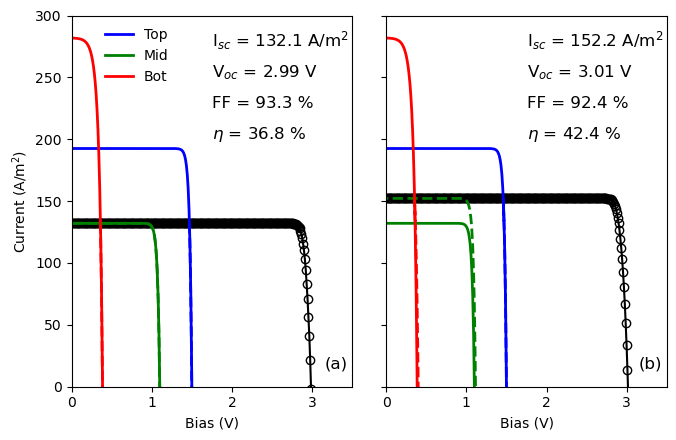

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from solcore.structure import Junction
from solcore.solar_cell import SolarCell
from solcore.light_source import LightSource
from solcore.solar_cell_solver import solar_cell_solver
from solcore.graphing.Custom_Colours import colours

# TODO This needs some explanations/descriptions

T = 298

Vin = np.linspace(-6, 2, 600)
V = np.linspace(-1.5, 4, 500)
wl = np.linspace(350, 2000, 301) * 1e-9
light_source = LightSource(source_type='standard', version='AM1.5g',
                           x=wl, output_units='photon_flux_per_m',
                           concentration=1)

color = ['b', 'g', 'r']
label = ['Top', 'Mid', 'Bot']

fig, ax = plt.subplots(1, 2, sharey='all', figsize=(7, 4.5))

for k, rad in enumerate([False, True]):

    # Input data for the 2D kind of junction
    db_junction = Junction(kind='2D', T=T, reff=0.3,
                           jref=300, Eg=0.66, A=1, R_shunt=np.inf, n=1)
    db_junction2 = Junction(kind='2D', T=T, reff=1,
                            jref=300, Eg=1.4, A=1, R_shunt=np.inf, n=1)
    db_junction3 = Junction(kind='2D', T=T, reff=1,
                            jref=300, Eg=1.8, A=1, R_shunt=np.inf, n=1)
    # n is the ideality factor of the diode. It is 1 for a perfect diode,
    # but can be higher for a real diode.

    my_solar_cell = SolarCell([db_junction3, db_junction2, db_junction],
                              T=T, R_series=0)

    solar_cell_solver(my_solar_cell, 'iv',
                      user_options={'T_ambient': T, 'voltages': V,
                                    'light_iv': True, 'wavelength': wl,
                                    'light_source': light_source,
                                    'radiative_coupling': rad, 'mpp': True,
                                    'internal_voltages': Vin})

    # This is the total junction IV
    ax[k].plot(my_solar_cell.iv['IV'][0], my_solar_cell.iv['IV'][1], marker='o',
               color=colours("Black"), ls='-',
               markerfacecolor='none', markeredgecolor=colours("Black"))

    # This is the junction IV when it is in the MJ device, including coupling if it
    # is enabled.
    for i, data in enumerate(my_solar_cell.iv['junction IV']):
        ax[k].plot(data[0], data[1], color[i] + '--', linewidth=2)

    # This is the junction IV as if it were an isolated device and therefore not
    # affected by coupling or current limiting.
    for i in range(my_solar_cell.junctions):
        ax[k].plot(V, -my_solar_cell(i).iv(V), color[i], linewidth=2, label=label[i])

    ax[k].set_ylim(0, 300)
    ax[k].set_xlim(0, 3.5)

    ax[k].set_xlabel('Bias (V)')

    Isc = my_solar_cell.iv["Isc"]
    Voc = my_solar_cell.iv["Voc"]
    FF = my_solar_cell.iv["FF"] * 100
    Eta = my_solar_cell.iv["Eta"] * 100

    ax[k].text(1.75, 275, 'I$_{sc}$ = ' + str(round(Isc, 1)) + ' A/m$^2$', fontsize=12)
    ax[k].text(1.75, 250, 'V$_{oc}$ = ' + str(round(Voc, 2)) + ' V', fontsize=12)
    ax[k].text(1.75, 225, 'FF = {:.1f} %'.format(FF), fontsize=12)
    ax[k].text(1.75, 200, r'$\eta$ = {:.1f} %'.format(Eta), fontsize=12)

ax[0].set_ylabel('Current (A/m$^2$)')
ax[0].text(0.9, 0.05, '(a)', transform=ax[0].transAxes, fontsize=12)
ax[1].text(0.9, 0.05, '(b)', transform=ax[1].transAxes, fontsize=12)
plt.tight_layout()
ax[0].legend(loc=(0.10, 0.80), frameon=False)
plt.show()

In [ ]:

# # for i in sim_mat.__dict__:
# #     print(i)
# # print(ToStructure(sim_mat))
# # print(str(sim_mat))
# for i in sim_mat.__dict__:
#     print(i)
# data_test = dict(
#     T=sim_mat.T,
#     absorbed=sim_mat.absorbed,
#     short_circuit_data=sim_mat[0].short_circuit_data.copy(),
#     pdd_data=sim_mat[0].pdd_data.copy(),
#     recombination_currents=sim_mat[0].recombination_currents.copy(),
#     equilibrium_data=sim_mat[0].equilibrium_data.copy(),    
#     iv=sim_mat.iv.copy(),
#     offset=sim_mat[0].offset
# )
# print('======================')
# print(data_test["iv"]["Pmpp"])
# for i in data_test["iv"]['Bandstructure']:
#     print(i)

# # with open(f'yoyo.pkl', 'wb') as fin:
# #     pickle.dump(sim_mat[0], fin)    

In [ ]:
# flash = State
# flash.meshpoints = -400
# flash.growth_rate = 0.7
# flash.coarse = 20e-9
# flash.fine = 1e-9
# flash.ultrafine = 0.2e-9
# flash.RTol = 1e-4
# flash.clamp = 20
# for i in flash.__dict__:
#     print(i)

In [ ]:
plt.plot(sim_mat['dot size =1.00e-01 nm'].pdd_data['negative_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['negative_V']['Bandstructure']['Ec'], label="Ec" )
plt.plot(sim_mat['dot size =1.00e-01 nm'].pdd_data['negative_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['negative_V']['Bandstructure']['Ev'], label="Ev")
plt.plot(sim_mat['dot size =1.00e-01 nm'].pdd_data['negative_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['negative_V']['Bandstructure']['Efe'],label="Efe")
plt.plot(sim_mat['dot size =1.00e-01 nm'].pdd_data['negative_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['negative_V']['Bandstructure']['Efh'],label="Efh")
plt.plot(sim_mat['dot size =1.00e-01 nm'].pdd_data['negative_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['negative_V']['Bandstructure']['potential'],label="potential")

In [ ]:
plt.plot(sim_mat['dot size =1.00e-01 nm'].pdd_data['positive_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['positive_V']['Bandstructure']['Ec'],'b', label="Ec" )
plt.plot(sim_mat['dot size =1.00e-01 nm'].pdd_data['positive_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['positive_V']['Bandstructure']['Ev'],'r',label="Ev")
plt.plot(sim_mat['dot size =1.00e-01 nm'].pdd_data['positive_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['positive_V']['Bandstructure']['Efe'],'b--', label="Efe")
plt.plot(sim_mat['dot size =1.00e-01 nm'].pdd_data['positive_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['positive_V']['Bandstructure']['Efh'],'r--',label="Efh")
plt.plot(sim_mat['dot size =1.00e-01 nm'].pdd_data['positive_V']['Bandstructure']['x']*1e9, sim_mat[0].pdd_data['positive_V']['Bandstructure']['potential'],label="potential")

In [2]:
wl = np.linspace(350, 3000, 401) * 1e-9  # version1
light_source = LightSource(source_type="standard"
                           , version="AM1.5g"
                           , x=wl
                           , output_units="photon_flux_per_m"
                           , concentration=1
                           )
vint = np.linspace(-3, 3, 600)
V = np.linspace(-1.5, 0, 300)  # np
# V = np.linspace(-3.5, 3.5, 300)
# V = np.linspace(0,3.5,300) # pn
con_light = np.logspace(0, 3, 5)
# con_light = np.linspace(1, 2, 5)

data = {"allI": [],
        "Isc": [],
        "Voc": [],
        "FF": [],
        "Pmpp": [],
        "absorbed": [],
        "xsc": [],
        "nsc": [],
        "psc": [],
        "xeq": [],
        "neq": [],
        "peq": [],
        }
deta_mode = {
    "allI": [],
    "Isc": [],
    "Voc": [],
    "FF": [],
    "Pmpp": [],
    "absorbed": [],
    "mode": [],
    "xsc": [],
    "nsc": [],
    "psc": [],
    "xeq": [],
    "neq": [],
    "peq": [],
}
set_of_data = []